<h1 align="center"> Personalized Medicine: Redefining Cancer Treatment</h1>

<h2>Description</h2>

<h3>Objective:</h3> Classify the given genetic variations/mutations based on evidence from text-based clinical literature.


<h3>Performance metric:</h3> Multi class log-loss , confusion matrix


<h3>Constarints:</h3>
<ul>
<li>No low-latency requirement
<li>Interpretability is important
<li>Errors can be very costly
<li>Probability of a data-point belonging to each class is needed
</ul>

<h3>Data overview</h3>
Source: https://www.kaggle.com/c/msk-redefining-cancer-treatment/data

 We have two data files: one conatins the information about the genetic mutations and the other contains the clinical evidence (text) that  human experts/pathologists use to classify the genetic mutations.  Both these data files are have a common column called ID.
 
 Data files include:
<ul>
<li> <b>training_variants</b>  -  a comma separated file containing the description of the genetic mutations used for training. Fields are ID (the id of the row used to link the mutation to the clinical evidence), Gene (the gene where this genetic mutation is located), Variation (the aminoacid change for this mutations), Class (1-9 the class this genetic mutation has been classified on)
<li> <b>training_text</b>  -  a double pipe (||) delimited file that contains the clinical evidence (text) used to classify genetic mutations. Fields are ID (the id of the row used to link the clinical evidence to the genetic mutation), Text (the clinical evidence used to classify the genetic mutation)
</ul>


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from time import process_time
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import log_loss
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import GridSearchCV
import math
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import defaultdict
from scipy.sparse import hstack
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score
import warnings
warnings.filterwarnings("ignore")
from prettytable import PrettyTable


<h2>Reading Data</h2>

In [2]:
# Reading Gene and Variation Data
data=pd.read_csv("../input/msk-redefining-cancer-treatment/training_variants",index_col='ID')
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3321 entries, 0 to 3320
Data columns (total 3 columns):
Gene         3321 non-null object
Variation    3321 non-null object
Class        3321 non-null int64
dtypes: int64(1), object(2)
memory usage: 103.8+ KB


,Gene,Variation,Class
ID,,,
0,FAM58A,Truncating Mutations,1
1,CBL,W802*,2
2,CBL,Q249E,2
3,CBL,N454D,3
4,CBL,L399V,4


In [3]:
# Reading Text data
data_text=pd.read_csv('../input/msk-redefining-cancer-treatment/training_text',sep='\|\|',engine='python',names=['ID','Text'],skiprows=1,index_col='ID')
print(data_text.info())
data_text.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3321 entries, 0 to 3320
Data columns (total 1 columns):
Text    3316 non-null object
dtypes: object(1)
memory usage: 51.9+ KB
None


,Text
ID,
0,Cyclin-dependent kinases (CDKs) regulate a var...
1,Abstract Background Non-small cell lung canc...
2,Abstract Background Non-small cell lung canc...
3,Recent evidence has demonstrated that acquired...
4,Oncogenic mutations in the monomeric Casitas B...


<h3> Preprocessing of text</h3>

In [4]:
# loading stop words from nltk library
stop_words=set(stopwords.words('english'))

def preprocessing(text):
    # replace every special char with space
    text=re.sub('[^a-zA-Z0-9]',' ',text)
     # replace multiple spaces with single space
    text=re.sub('\s+',' ',text)
    # converting all the chars into lower-case.
    text=text.lower()
    string=""
    for word in text.split():
    # if the word is a not a stop word then retain that word from the data
        if word not in stop_words:
            string+=word+' '
    return string

In [5]:
#text processing stage.
start_time=process_time()
data_text['Text']=data_text['Text'].apply(lambda text:preprocessing(text) if type(text)==str else np.NaN)
print('Time taken for preprocessing :',process_time()-start_time)

Time taken for preprocessing : 34.986455998


In [6]:
#merging both gene_variations and text data based on ID
df=pd.merge(data,data_text,on='ID',how='left')
df.head()

,Gene,Variation,Class,Text
ID,,,,
0,FAM58A,Truncating Mutations,1,cyclin dependent kinases cdks regulate variety...
1,CBL,W802*,2,abstract background non small cell lung cancer...
2,CBL,Q249E,2,abstract background non small cell lung cancer...
3,CBL,N454D,3,recent evidence demonstrated acquired uniparen...
4,CBL,L399V,4,oncogenic mutations monomeric casitas b lineag...


In [7]:
df[df.isnull().any(axis=1)]

,Gene,Variation,Class,Text
ID,,,,
1109,FANCA,S1088F,1,NaN
1277,ARID5B,Truncating Mutations,1,NaN
1407,FGFR3,K508M,6,NaN
1639,FLT1,Amplification,6,NaN
2755,BRAF,G596C,7,NaN


In [8]:
# If text is null, text='gene variation'
df.loc[df['Text'].isnull(),'Text']=df['Gene']+' '+df['Variation']

In [9]:
df.iloc[1109]

Gene                FANCA
Variation          S1088F
Class                   1
Text         FANCA S1088F
Name: 1109, dtype: object

<h3>Splitting data into train and test (80:20)</h3>

In [10]:
y=df['Class'].values
df['Gene']=df.Gene.str.replace('\s+','_')
df['Variation']=df.Variation.str.replace('\s+','_')

 We split the data into train and test set preserving the ratio of class distribution in the original data set 

In [11]:
x_train,x_test,y_train,y_test=train_test_split(df,y,test_size=0.2,stratify=y,random_state=1)
print('Number of point in train data :',x_train.shape[0])
print('Number of point in test data :',x_test.shape[0])

Number of point in train data : 2656
Number of point in test data : 665


<h3> Distribution of y_i's in Train and Test datasets</h3>

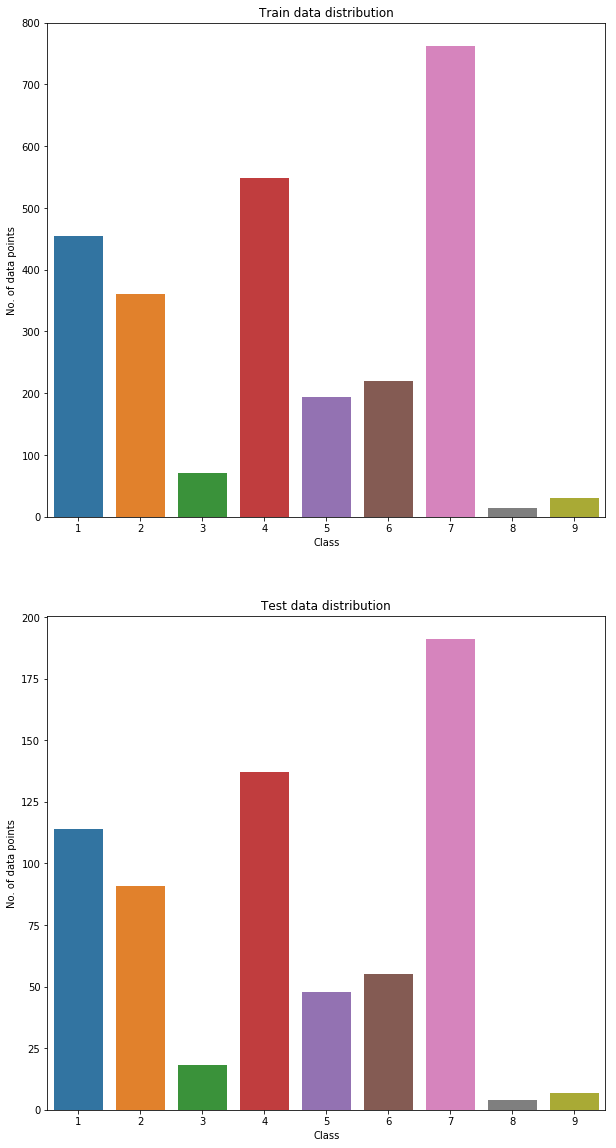

In [12]:
_,axes=plt.subplots(2,1,figsize=(10,20))
train_dist=x_train['Class'].value_counts(sort=False)
test_dist=x_test['Class'].value_counts(sort=False)

sns.barplot(train_dist.index,train_dist.values,ax=axes[0])
axes[0].set_title('Train data distribution')
axes[0].set_xlabel('Class')
axes[0].set_ylabel('No. of data points')

sns.barplot(test_dist.index,test_dist.values,ax=axes[1])
axes[1].set_title('Test data distribution')
axes[1].set_xlabel('Class')
axes[1].set_ylabel('No. of data points')
plt.show()

<h2>Prediction using a Random Model</h2>

In [13]:
# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    
    A =(((C.T)/(C.sum(axis=1))).T)
    #divid each element of the confusion matrix with the sum of elements in that column
    
    # C = [[1, 2],
    #     [3, 4]]
    # C.T = [[1, 3],
    #        [2, 4]]
    # C.sum(axis = 1)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =1) = [[3, 7]]
    # ((C.T)/(C.sum(axis=1))) = [[1/3, 3/7]
    #                           [2/3, 4/7]]

    # ((C.T)/(C.sum(axis=1))).T = [[1/3, 2/3]
    #                           [3/7, 4/7]]
    # sum of row elements = 1
    
    B =(C/C.sum(axis=0))
    #divid each element of the confusion matrix with the sum of elements in that row
    # C = [[1, 2],
    #     [3, 4]]
    # C.sum(axis = 0)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =0) = [[4, 6]]
    # (C/C.sum(axis=0)) = [[1/4, 2/6],
    #                      [3/4, 4/6]] 
    
    labels = [1,2,3,4,5,6,7,8,9]
    # representing A in heatmap format
    print("-"*20, "Confusion matrix", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(C, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

    print("-"*20, "Precision matrix (Columm Sum=1)", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(B, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    
    # representing B in heatmap format
    print("-"*20, "Recall matrix (Row sum=1)", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(A, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

Log loss on Test Data using Random Model 2.494196538109259
-------------------- Confusion matrix --------------------


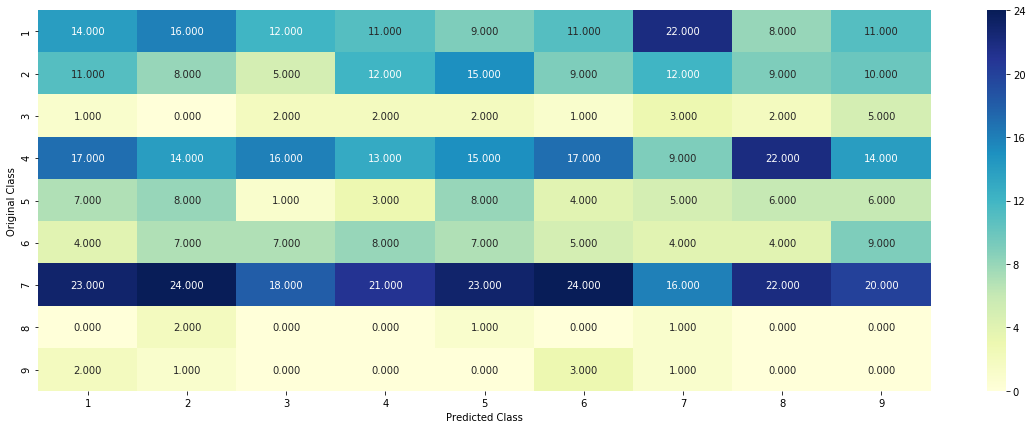

-------------------- Precision matrix (Columm Sum=1) --------------------


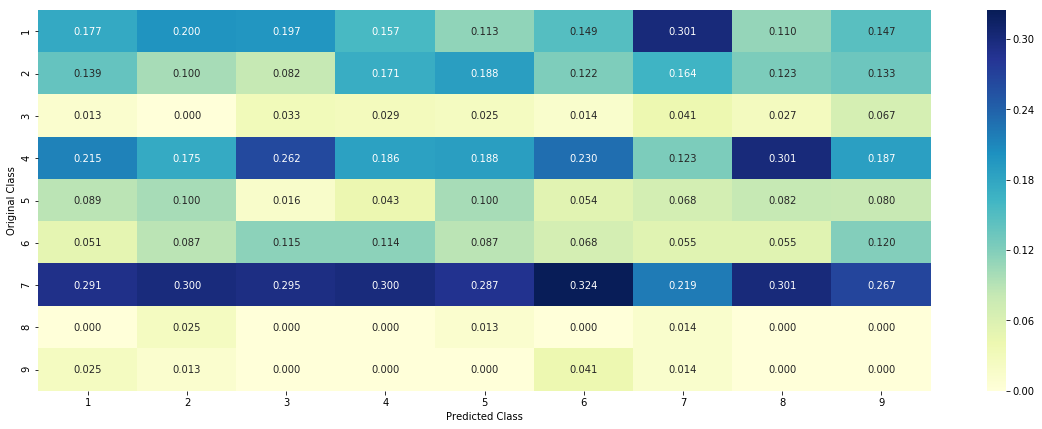

-------------------- Recall matrix (Row sum=1) --------------------


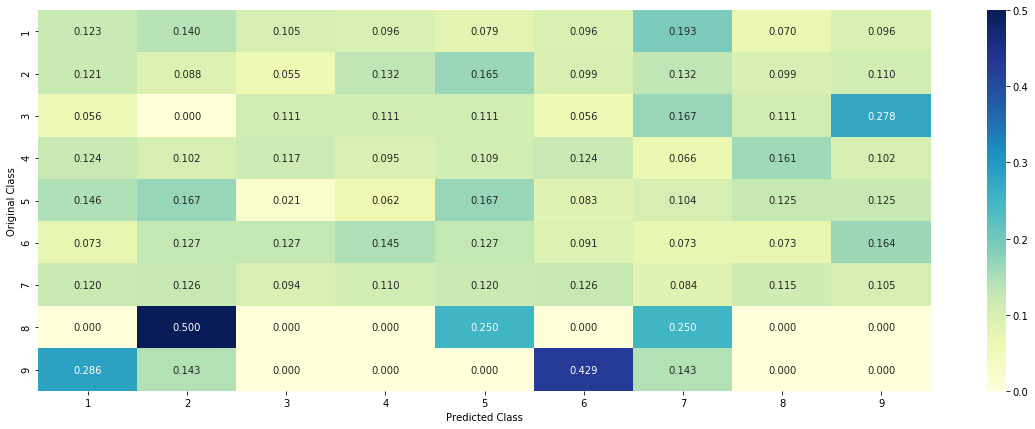

In [14]:
test_rand=np.zeros((y_test.shape[0],9))

for i in range(test_rand.shape[0]):
    prob=np.random.rand(1,9)
    test_rand[i]=prob/np.sum(prob)
print("Log loss on Test Data using Random Model",log_loss(y_test,test_rand))

rand_y =np.argmax(test_rand, axis=1)
plot_confusion_matrix(y_test,rand_y+1)

<h2>Univariate Analysis</h2>

In [15]:
# Target encoding with Laplace smoothing.

def target_encoding(alpha,feature,df):
    # value_count will contain the number of time a particular feature occured in whole data
    value_count=x_train[feature].value_counts()
    # feature_dict : Dictionary containing the probability array for each feature
    feature_dict=dict()
    for i,count in value_count.items():
        # arr will contain p(yi==1/Gi) probability of feature belongs to particular class
        # arr is 9 diamensional vector
        arr=[]
        for j in range(1,10):
            # class_count is the number of occurences of the feature in that particular class
            class_count=x_train.loc[(x_train['Class']==j) & (x_train[feature]==i)].shape[0]
            # perform laplace smoothing
            arr.append((class_count+alpha)/(count+9*alpha))
        feature_dict[i]=arr
    
    encoding_list=[]
    # for every feature values in the given data frame we will check if it is there in the train data then we will add the feature to encoding_list
    # if not we will add [1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9] to encoding_list
    for index,row in df.iterrows():
        if row[feature] in feature_dict:
            encoding_list.append(feature_dict[row[feature]])
        else:
            encoding_list.append([1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9])
    return np.array(encoding_list)

<h3>Univariate Analysis on Gene Feature</h3>

Number of Unique Genes : 253
BRCA1     205
TP53      138
EGFR      108
PTEN      104
BRCA2     103
BRAF       80
KIT        75
ERBB2      54
ALK        51
PDGFRA     48
Name: Gene, dtype: int64


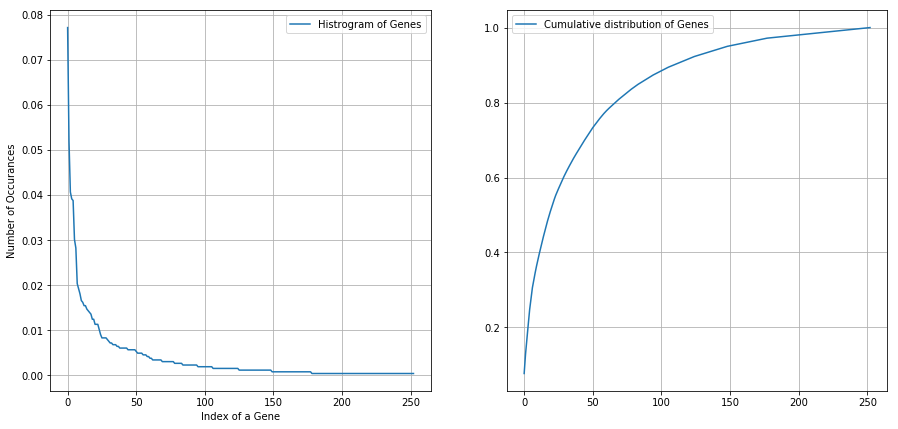

In [16]:
unique_genes=x_train['Gene'].value_counts()
print("Number of Unique Genes :",unique_genes.shape[0])
# the top 10 genes that occured most
print(unique_genes.head(10))
s=np.sum(unique_genes.values)
hist=unique_genes.values/s
cdf=np.cumsum(hist)
_,axes=plt.subplots(1,2,figsize=(15,7))
axes[0].plot(hist, label="Histrogram of Genes")
axes[0].set_xlabel('Index of a Gene')
axes[0].set_ylabel('Number of Occurances')
axes[0].legend()
axes[0].grid()
axes[1].plot(cdf, label="Cumulative distribution of Genes")
axes[1].legend()
axes[1].grid()
plt.show()

We can featurize this variable using
<ol>
    <li> One hot encoding
    <li> Target encoding
</ol>
 One hot encoding is better for Logistic regression while Target encoding is better for Random Forests.

In [17]:
# Target encoding of Gene feature
# alpha is used for laplace smoothing
alpha = 1

gene_target_encoding_train=target_encoding(alpha,'Gene',x_train)
gene_target_encoding_test=target_encoding(alpha,'Gene',x_test)

In [18]:
# One hot encoding of Gene feature.
gene_ohe=OneHotEncoder(dtype=np.int8,handle_unknown='ignore')

gene_onehot_train=gene_ohe.fit_transform(np.reshape(np.array(x_train['Gene']),(-1,1)))
gene_onehot_test=gene_ohe.transform(np.reshape(np.array(x_test['Gene']),(-1,1)))

How good is gene feature  in predicting y_i?

We can build a logistic regression model using only Gene feature (one hot encoded) to predict y_i.

In [19]:
print('Percentage of data point in Test dataset containing genes not present in Train dataset :',(1-x_test[x_test['Gene'].isin(set(x_train['Gene']))].shape[0]/x_test.shape[0])*100)

Percentage of data point in Test dataset containing genes not present in Train dataset : 1.9548872180451093


Gene feature is stable across Train and Test datasets.

<h3>Univariate Analysis on Variation Feature</h3>

Number of Unique Variations : 2393
Truncating_Mutations    73
Amplification           62
Deletion                54
Fusions                 31
Overexpression           5
G12V                     4
Q61L                     3
T58I                     3
Q61R                     2
Q61H                     2
Name: Variation, dtype: int64


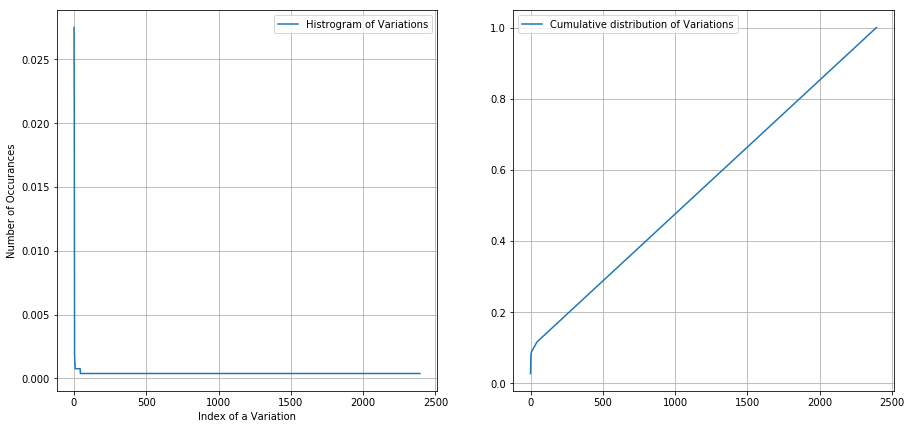

In [20]:
unique_variation=x_train['Variation'].value_counts()
print("Number of Unique Variations :",unique_variation.shape[0])
# the top 10 variations that occured most
print(unique_variation.head(10))
s=np.sum(unique_variation.values)
hist=unique_variation.values/s
cdf=np.cumsum(hist)
_,axes=plt.subplots(1,2,figsize=(15,7))
axes[0].plot(hist, label="Histrogram of Variations")
axes[0].set_xlabel('Index of a Variation')
axes[0].set_ylabel('Number of Occurances')
axes[0].legend()
axes[0].grid()
axes[1].plot(cdf, label="Cumulative distribution of Variations")
axes[1].legend()
axes[1].grid()
plt.show()

We will use both one hot encoding and target encoding methods to featurize the Variation Feature </p>

In [21]:
# alpha is used for laplace smoothing
alpha=1

variation_target_encoding_train=target_encoding(alpha,'Variation',x_train)
variation_target_encoding_test=target_encoding(alpha,'Variation',x_test)

In [22]:
# one-hot encoding of variation feature.
variation_ohe=OneHotEncoder(dtype=np.int8,handle_unknown='ignore')

variation_onehot_train=variation_ohe.fit_transform(np.reshape(np.array(x_train['Variation']),(-1,1)))
variation_onehot_test=variation_ohe.transform(np.reshape(np.array(x_test['Variation']),(-1,1)))

How good is this Variation feature  in predicting y_i?

We can build a logistic regression model using only Variation feature (one hot encoded) to predict y_i.

In [23]:
clf=LogisticRegression(solver='liblinear',multi_class='auto')
grid=GridSearchCV(clf,param_grid={'C':[10**-2,10**-1,1,10,100]},n_jobs=-1,cv=5,return_train_score=True)
grid.fit(variation_onehot_train,y_train)
calib_clf=CalibratedClassifierCV(clf,cv=5)
calib_clf.fit(variation_onehot_train,y_train)
prob=calib_clf.predict_proba(variation_onehot_train)
print("Train log loss using only Variation feature :",log_loss(y_train,prob))
prob=calib_clf.predict_proba(variation_onehot_test)
print("Test log loss using only Variation feature :",log_loss(y_test,prob))

Train log loss using only Variation feature : 1.0722245169589326
Test log loss using only Variation feature : 1.7342387831525712


In [24]:
print('Percentage of data point in Test dataset containing variations not present in Train dataset :',(1-x_test[x_test['Variation'].isin(set(x_train['Variation']))].shape[0]/x_test.shape[0])*100)

Percentage of data point in Test dataset containing variations not present in Train dataset : 90.67669172932331


Variation feature is not stable across Train and Test datasets

<h3>Univariate Analysis on Text Feature</h3>

In [25]:
# TF-IDF

tfidf=TfidfVectorizer(max_features=2000,ngram_range=(1,3))
text_feature_train=tfidf.fit_transform(x_train['Text'])
text_feature_test=tfidf.transform(x_test['Text'])

In [26]:
clf=LogisticRegression(solver='liblinear',multi_class='auto')
grid=GridSearchCV(clf,param_grid={'C':[10**-2,10**-1,1,10,100]},n_jobs=-1,cv=5,return_train_score=True)
grid.fit(text_feature_train,y_train)
calib_clf=CalibratedClassifierCV(clf,cv=5)
calib_clf.fit(text_feature_train,y_train)
prob=calib_clf.predict_proba(text_feature_train)
print("Train log loss using only Text feature :",log_loss(y_train,prob))
prob=calib_clf.predict_proba(text_feature_test)
print("Test log loss using only Text feature :",log_loss(y_test,prob))

Train log loss using only Text feature : 0.93982916943413
Test log loss using only Text feature : 1.1188111421001252


Text feature seems to be stable accross Train and Test datasets as the difference between log loss of train and test set is small

In [27]:
def get_intersec_text(df):
    df_text_vec = TfidfVectorizer(min_df=3,max_features=1000)
    df_text_fea = df_text_vec.fit_transform(df['Text'])
    df_text_features = df_text_vec.get_feature_names()

    df_text_fea_counts = df_text_fea.sum(axis=0).A1
    df_text_fea_dict = dict(zip(list(df_text_features),df_text_fea_counts))
    len1 = len(set(df_text_features))
    len2 = len(set(tfidf.get_feature_names()) & set(df_text_features))
    return len1,len2

len1,len2 = get_intersec_text(x_test)
print(np.round((len2/len1)*100, 3), "% of word of test data appeared in train data")

99.5 % of word of test data appeared in train data


<h1>Machine Learning Models</h1>

In [28]:
#Stacking gene,variation and text features
train_gene_var_onehotCoding = hstack((gene_onehot_train,variation_onehot_train))
test_gene_var_onehotCoding = hstack((gene_onehot_test,variation_onehot_test))

x_train_onehot = hstack((train_gene_var_onehotCoding, text_feature_train)).tocsr()
x_test_onehot = hstack((test_gene_var_onehotCoding, text_feature_test)).tocsr()

scaler=StandardScaler(with_mean=False)
x_train_onehot=scaler.fit_transform(x_train_onehot)
x_test_onehot=scaler.transform(x_test_onehot)

train_gene_var_targetencoding = np.hstack((gene_target_encoding_train,variation_target_encoding_train))
test_gene_var_targetencoding = np.hstack((gene_target_encoding_test,variation_target_encoding_test))

x_train_target_encoding = hstack((train_gene_var_targetencoding, text_feature_train)).tocsr()
x_test_target_encoding = hstack((test_gene_var_targetencoding, text_feature_test)).tocsr()

print("Number of features in Onehot encoding :",x_train_onehot.shape[1])
print("Number of features in Target encoding :",x_train_target_encoding.shape[1])


Number of features in Onehot encoding : 4646
Number of features in Target encoding : 2018


In [29]:
#Function to print train and test scores and confusion matrix
comparison=[]

def display_score(clf,clf_name,onehot):
    if onehot:
        prob_train=clf.predict_proba(x_train_onehot)
        y_pred_train=clf.predict(x_train_onehot)
    else:
        prob_train=clf.predict_proba(x_train_target_encoding)
        y_pred_train=clf.predict(x_train_target_encoding)
    
    print("Train log loss :",log_loss(y_train,prob_train))
    if onehot:
        prob_test=clf.predict_proba(x_test_onehot)
        y_pred_test=clf.predict(x_test_onehot)
    else:
        prob_test=clf.predict_proba(x_test_target_encoding)
        y_pred_test=clf.predict(x_test_target_encoding)
    print("Test log loss :",log_loss(y_test,prob_test))
    print("Mis-classified points in Test dataset :", np.count_nonzero((y_pred_test- y_test))/y_test.shape[0])
    comparison.append([clf_name,np.round(log_loss(y_train,prob_train),4),np.round(log_loss(y_test,prob_test),4),np.round(np.count_nonzero((y_pred_test- y_test))/y_test.shape[0],4)])
    plot_confusion_matrix(y_test, np.argmax(prob_test,axis=1)+1)

<h2>Naive Bayes</h2>

Train log loss : 0.9207290355943172
Test log loss : 1.4643768423840957
Mis-classified points in Test dataset : 0.4496240601503759
-------------------- Confusion matrix --------------------


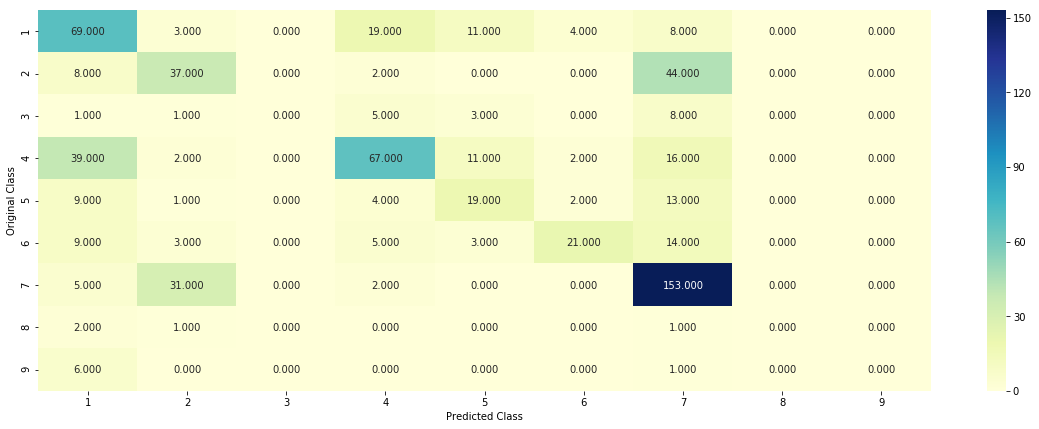

-------------------- Precision matrix (Columm Sum=1) --------------------


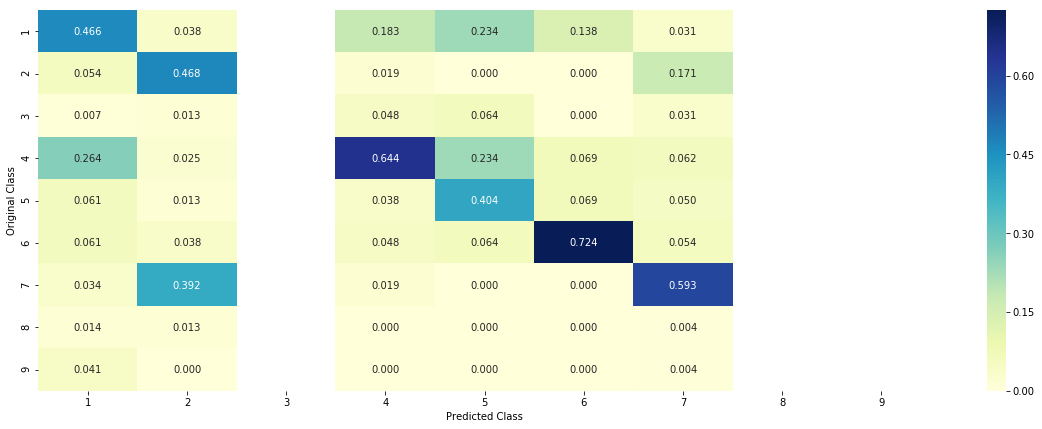

-------------------- Recall matrix (Row sum=1) --------------------


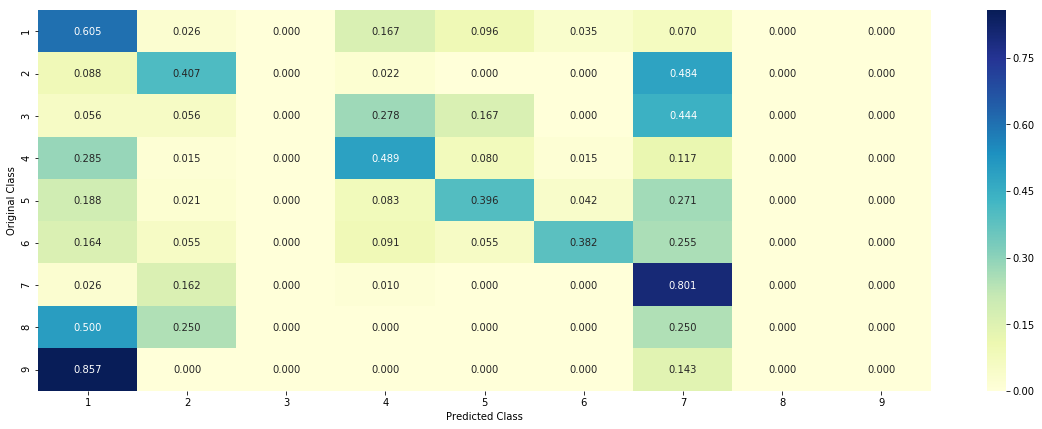

In [30]:
params = {'alpha':[0.0001, 0.001, 0.1, 1, 10, 100]}
clf=MultinomialNB()
grid=GridSearchCV(clf,param_grid=params,n_jobs=-1,cv=5,return_train_score=True,scoring='neg_log_loss')
grid.fit(x_train_onehot,y_train)
calib_clf=CalibratedClassifierCV(grid,cv=5)
calib_clf.fit(x_train_onehot,y_train)
display_score(calib_clf,'Naive Bayes',1)


<h2>Logistic Regression</h2>

Train log loss : 0.4778674079426128
Test log loss : 1.0566222591577208
Mis-classified points in Test dataset : 0.36541353383458647
-------------------- Confusion matrix --------------------


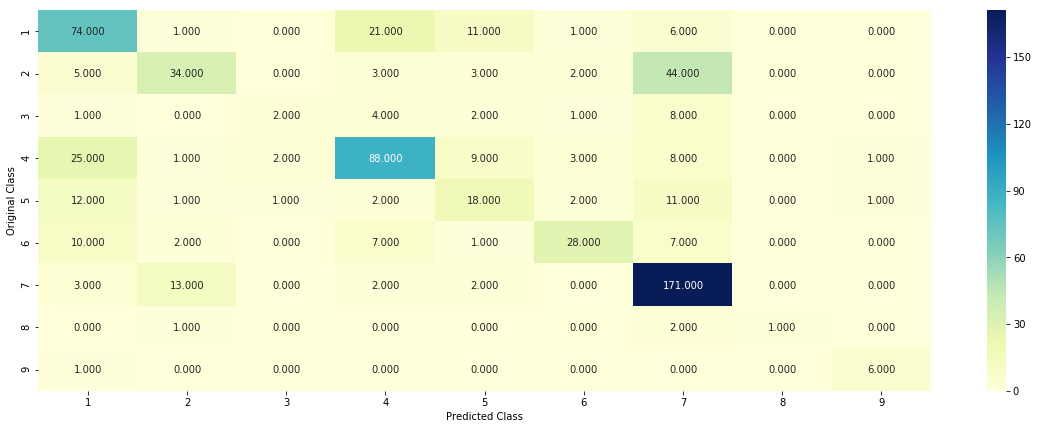

-------------------- Precision matrix (Columm Sum=1) --------------------


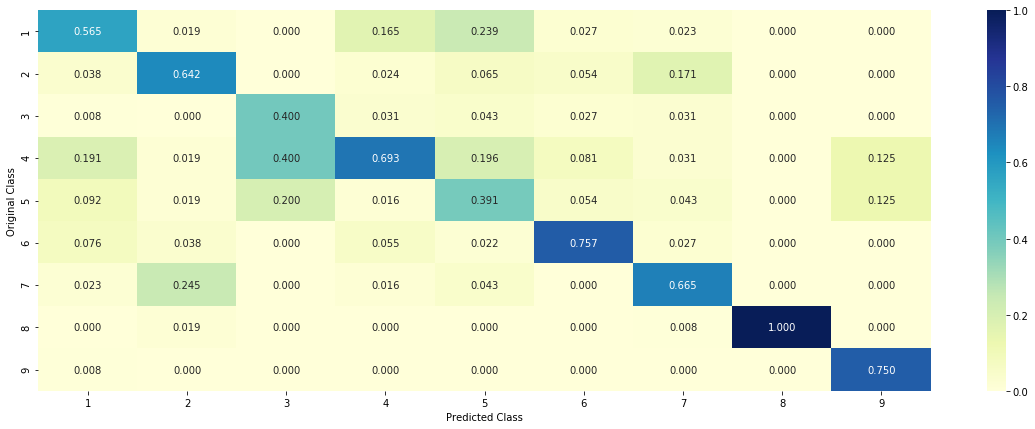

-------------------- Recall matrix (Row sum=1) --------------------


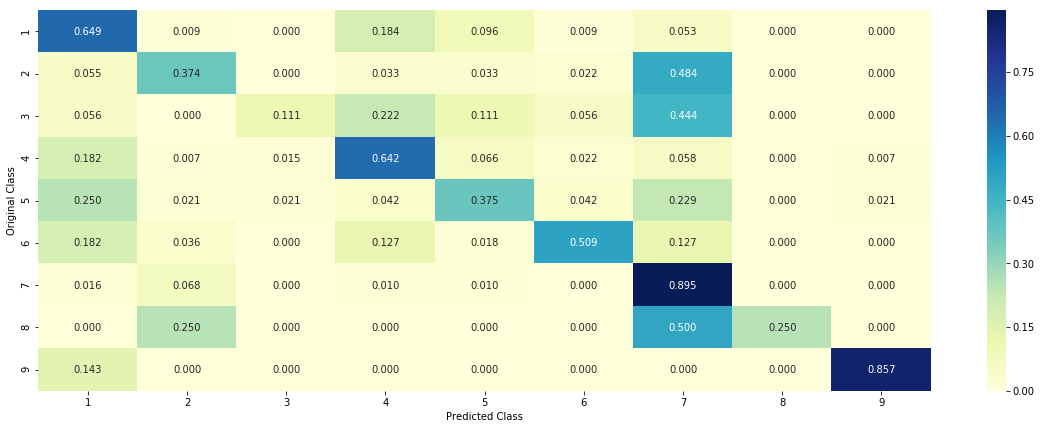

In [31]:
params={'C' : [0.001,0.01,0.1]}
clf=LogisticRegression(class_weight='balanced',random_state=0,solver='saga',multi_class='multinomial',n_jobs=-1)
grid=GridSearchCV(clf,param_grid=params,n_jobs=-1,cv=5,return_train_score=True,scoring='neg_log_loss')
grid.fit(x_train_onehot,y_train)
calib_clf=CalibratedClassifierCV(grid)
calib_clf.fit(x_train_onehot,y_train)
display_score(calib_clf,'Logistic Regression',1)

<h2>Linear Support Vector Machine</h2>

Train log loss : 0.378186025601814
Test log loss : 1.1032110010862552
Mis-classified points in Test dataset : 0.3699248120300752
-------------------- Confusion matrix --------------------


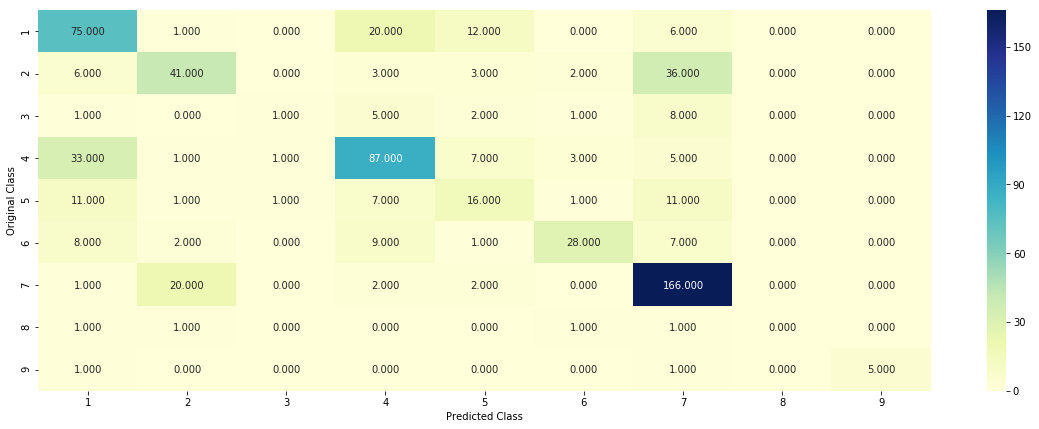

-------------------- Precision matrix (Columm Sum=1) --------------------


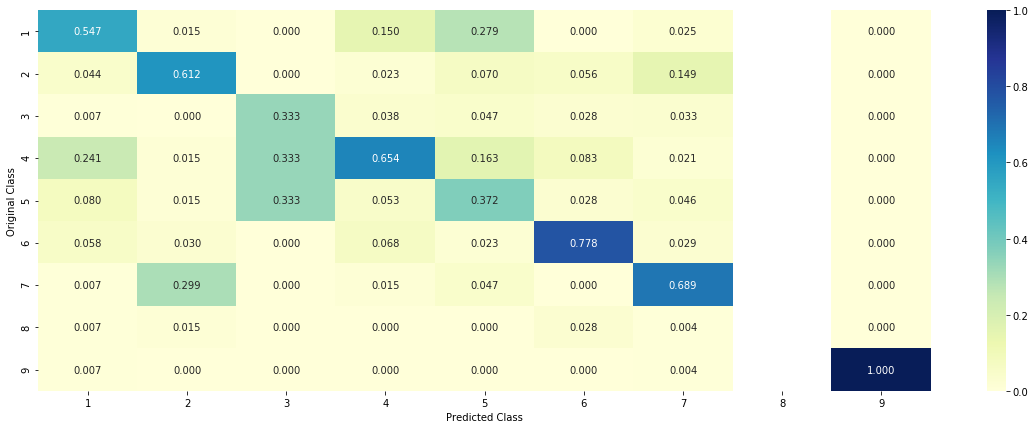

-------------------- Recall matrix (Row sum=1) --------------------


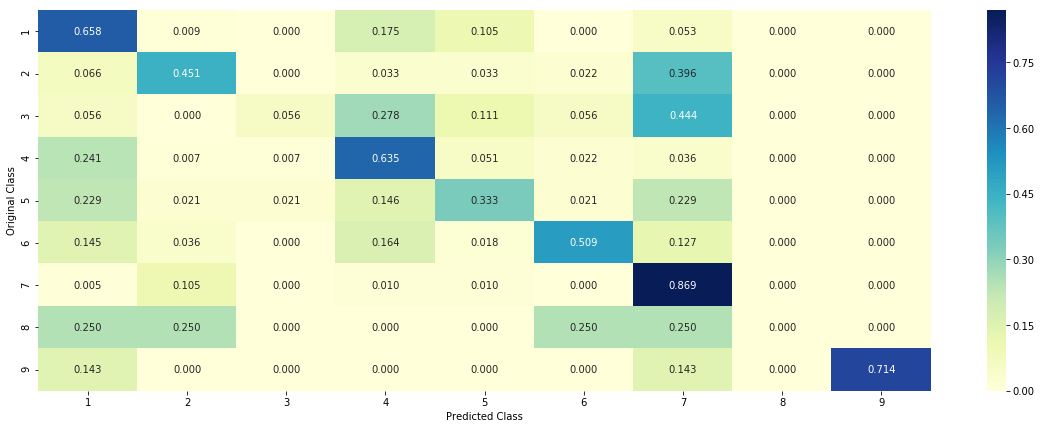

In [32]:
clf=LinearSVC(loss='hinge',class_weight='balanced',random_state=0)
clf.fit(x_train_onehot,y_train)
calib_clf=CalibratedClassifierCV(clf)
calib_clf.fit(x_train_onehot,y_train)
display_score(calib_clf,'Linear SVM',1)

<h2>Random Forest Classifier</h2>

Train log loss : 0.09482018704620711
Test log loss : 0.9226537583594692
Mis-classified points in Test dataset : 0.3172932330827068
-------------------- Confusion matrix --------------------


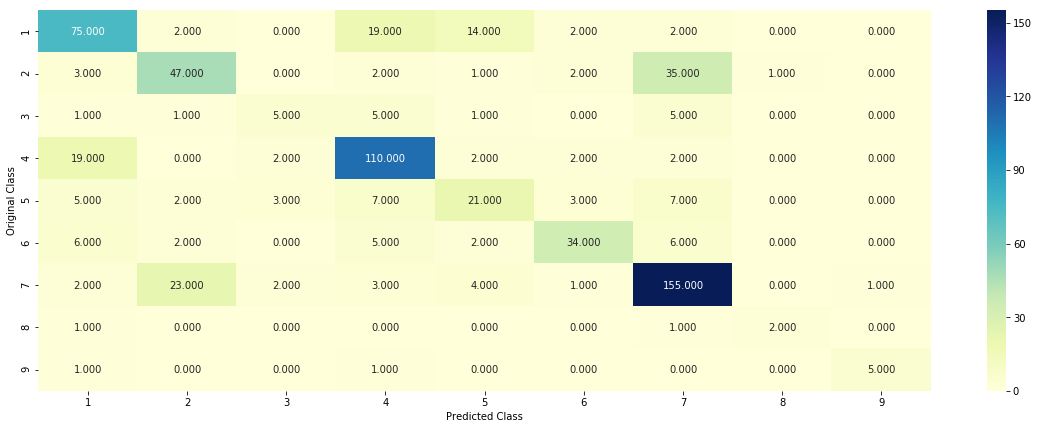

-------------------- Precision matrix (Columm Sum=1) --------------------


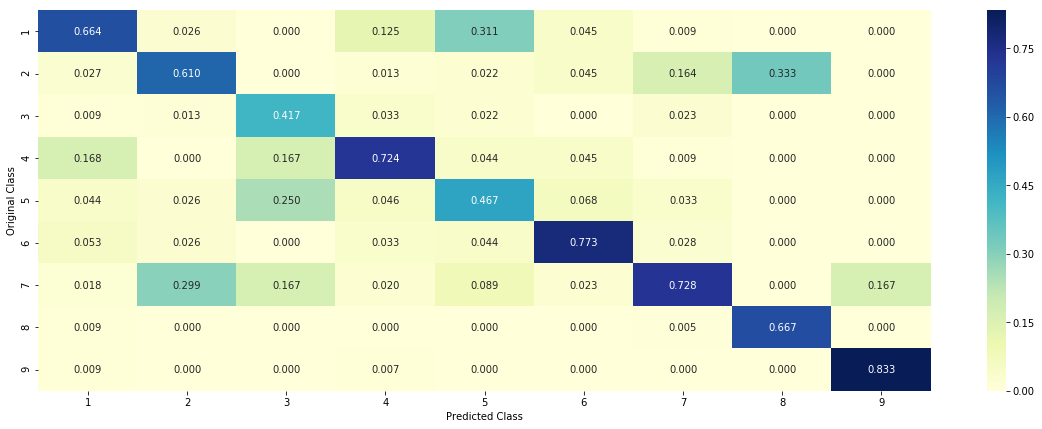

-------------------- Recall matrix (Row sum=1) --------------------


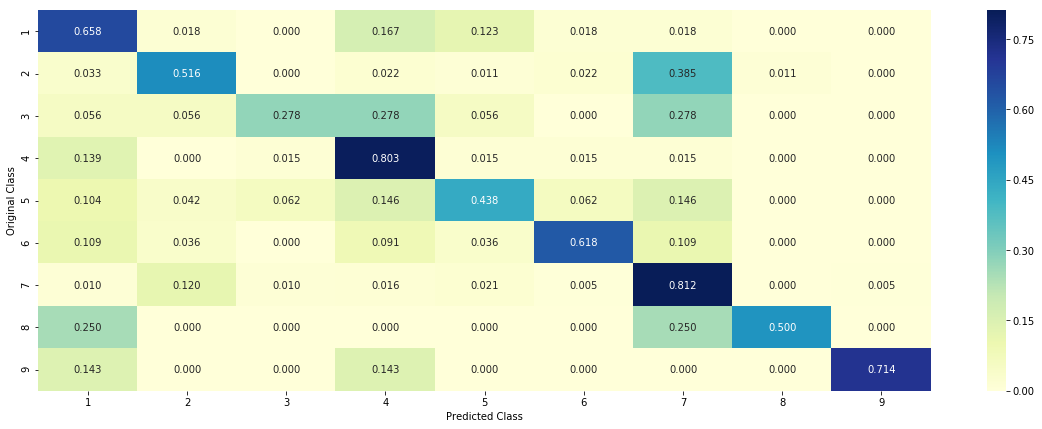

In [33]:
params={'n_estimators':[100,500]}
clf=RandomForestClassifier(n_jobs=-1,random_state=0,class_weight='balanced')
grid=GridSearchCV(clf,param_grid=params,n_jobs=-1,cv=5,return_train_score=True,scoring='neg_log_loss')
grid.fit(x_train_target_encoding,y_train)
calib_clf=CalibratedClassifierCV(grid)
calib_clf.fit(x_train_target_encoding,y_train)
display_score(calib_clf,'Random Forest',0)

<h2>Results</h2>

In [34]:
results=PrettyTable()
results.field_names = ["Classification model", "Train log loss", "Test log loss", "Misclassification"]
for i in comparison:
    results.add_row(i)
print(results)

+----------------------+----------------+---------------+-------------------+
| Classification model | Train log loss | Test log loss | Misclassification |
+----------------------+----------------+---------------+-------------------+
|     Naive Bayes      |     0.9207     |     1.4644    |       0.4496      |
| Logistic Regression  |     0.4779     |     1.0566    |       0.3654      |
|      Linear SVM      |     0.3782     |     1.1032    |       0.3699      |
|    Random Forest     |     0.0948     |     0.9227    |       0.3173      |
+----------------------+----------------+---------------+-------------------+


Random forest has the best performance.

<h2>Feature importance</h2>

In [35]:
data_index=1
top_features=100
print("Predicted Class :",calib_clf.predict(x_train_target_encoding[data_index])[0])
print("Actual Class :",y_train[data_index])
print("Probalities ",np.around(calib_clf.predict_proba(x_train_target_encoding[data_index])[0],4))
indices=np.argsort(-grid.best_estimator_.feature_importances_)[:top_features]
tfidf_features_names=tfidf.get_feature_names()
print("-"*50)
counter=0
for idx,i in enumerate(indices):
    if i>17 and tfidf_features_names[i-17] in x_train.iloc[data_index]['Text']:
        counter+=1
        print(idx+1,"Text feature [",tfidf_features_names[i-17],"] present in query point")
print()
print("Out of the top",top_features,"features,",counter,"are present in query point")

Predicted Class : 5
Actual Class : 5
Probalities  [0.1301 0.003  0.0078 0.0679 0.7011 0.082  0.0011 0.0034 0.0037]
--------------------------------------------------
21 Text feature [ variation ] present in query point
29 Text feature [ cells expressing ] present in query point
30 Text feature [ mutant p53 ] present in query point
48 Text feature [ samples ] present in query point
49 Text feature [ never ] present in query point
50 Text feature [ surface ] present in query point
59 Text feature [ assess ] present in query point
61 Text feature [ contains ] present in query point
64 Text feature [ indicated ] present in query point
65 Text feature [ activation ] present in query point
66 Text feature [ 17 ] present in query point
68 Text feature [ although ] present in query point
71 Text feature [ red ] present in query point
74 Text feature [ variants ] present in query point
76 Text feature [ experiment ] present in query point
77 Text feature [ conformation ] present in query point
